<a href="https://colab.research.google.com/github/reachsidd/fina_project_6740/blob/main/python/FinalProject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection

nltk.download('punkt')
nltk.download('stopwords')
import bs4
import wordcloud
import keras.preprocessing
import tensorflow as tf
import zipfile
import sklearn.pipeline
import sklearn.model_selection
import pprint
import tensorflow.keras.preprocessing.text
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# get raw text from htmls
def clean_html(text):
    soup = bs4.BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [3]:
# remove stopwords, punctuations and lower the case
def remove_stopwords_case_normalization(text):
    stopwords = nltk.corpus.stopwords.words('english')
    #print(stopwords)
    text_new = text.lower()
    text_new = re.sub('[^a-z]', ' ', text_new)
    # print(text_new)
    text_new = "".join([i for i in text_new if i not in string.punctuation])
    #print(text_new)
    words = text_new.split()
    #print(words)
    text_new = " ".join([i for i in words if i not in stopwords])
    #print(text_new)
    return text_new

In [4]:
def clean_text(text):
    # Remove urls
    text_new = re.sub(r'http\S+', '', text)
    text_new = clean_html(text_new)
    text_new = remove_stopwords_case_normalization(text_new)
    return text_new

# **1.    Exploratory Data Analysis (EDA)**







##Preparing the dataset

In [5]:
fake_github_url = 'https://github.com/reachsidd/fina_project_6740/blob/main/data/Fake.zip?raw=true'
true_github_url = 'https://github.com/reachsidd/fina_project_6740/blob/main/data/True.zip?raw=true'

fake_data_original = pd.read_csv(fake_github_url, compression='zip')
true_data_original = pd.read_csv(true_github_url, compression='zip')

# null check
print(fake_data_original.isna().sum())
# null check
print(true_data_original.isna().sum())

# true_data_original.head()

title      0
text       0
subject    0
date       0
dtype: int64
title      0
text       0
subject    0
date       0
dtype: int64


##Cleaning the data

In [6]:
fake_data = fake_data_original.copy()
true_data = true_data_original.copy()

fake_data['content'] = fake_data['title'] + ' ' + fake_data['text']
fake_data['label'] = 0
fake_data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)
# print(fake_data.head())

true_data['content'] = true_data['title'] + ' ' + true_data['text']
true_data['label'] = 1
true_data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)
# print(true_data.head())

fake_data['content'] = fake_data['content'].apply(clean_text)
# print(fake_data.head())

true_data['content'] = true_data['content'].apply(clean_text)
# print(true_data.head())


# FOR TESTING ONLY
# train = train.head(100)
# test = test.head(100)

## WORD CLOUD - True news

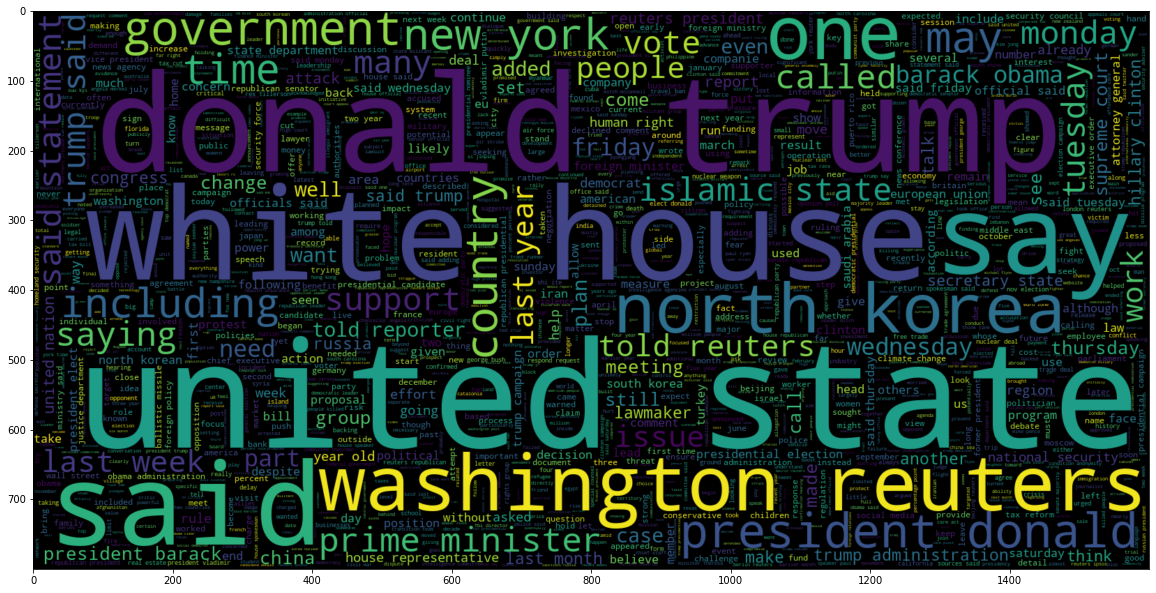

In [7]:
# WORDCLOUD FOR  CLEAN TEXT(LABEL - 1 - True)
plt.figure(figsize=(20, 20))  # Text that is not Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(
    " ".join(true_data.content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

## WORD CLOUD - False news

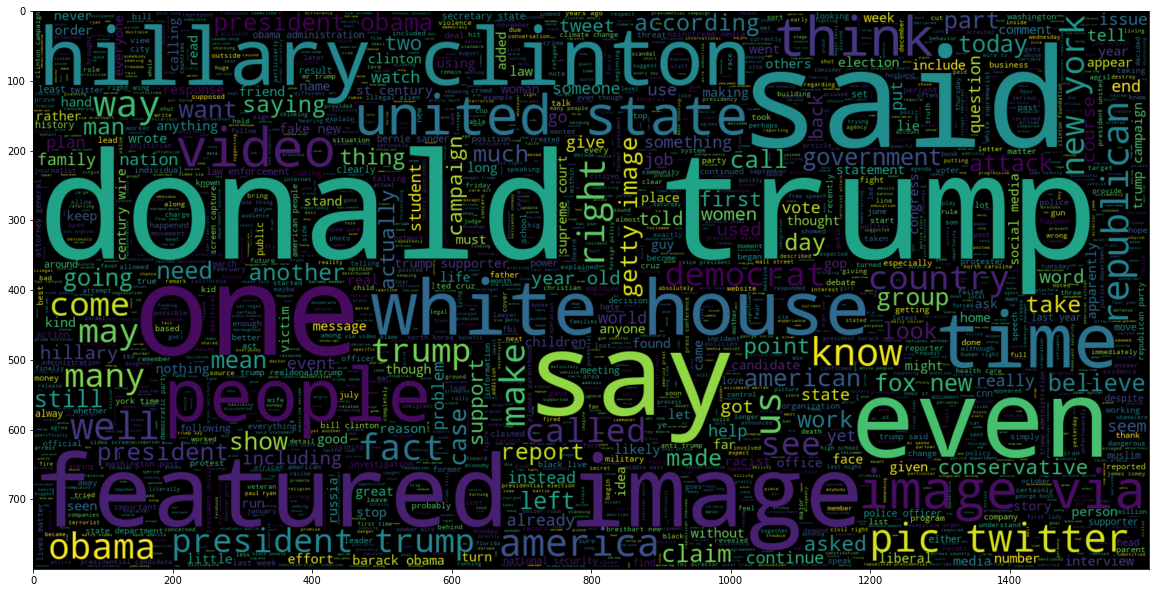

In [8]:
# WORDCLOUD FOR  FAKE TEXT(LABEL - 0 - fake)
plt.figure(figsize=(20, 20))  # Text that is Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(
    " ".join(fake_data.content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

##Comparison of the top 10 most frequent words in news text between true & fake news

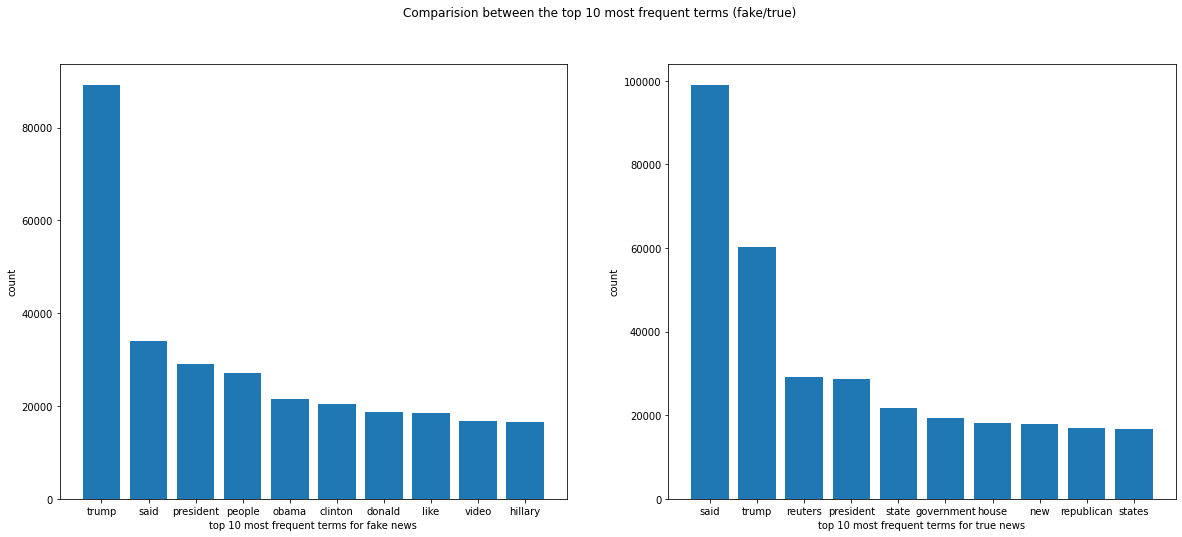

In [9]:
def get_top_n_words(corpus, n=None):
    corpus_fake = corpus[corpus['label'] == 0].astype(str)['content']
    corpus_true = corpus[corpus['label'] == 1].astype(str)['content']

    vec = sklearn.feature_extraction.text.CountVectorizer(stop_words='english').fit(corpus_fake)
    bag_of_words = vec.transform(corpus_fake)
    sum_words = bag_of_words.sum(axis=0)
    words_freq_fake = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq_fake = sorted(words_freq_fake, key=lambda x: x[1], reverse=True)

    vec = sklearn.feature_extraction.text.CountVectorizer(stop_words='english').fit(corpus_true)
    bag_of_words = vec.transform(corpus_true)
    sum_words = bag_of_words.sum(axis=0)
    words_freq_true = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq_true = sorted(words_freq_true, key=lambda x: x[1], reverse=True)

    df_fake = pd.DataFrame(words_freq_fake[:n], columns=['text', 'count'])
    df_true = pd.DataFrame(words_freq_true[:n], columns=['text', 'count'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.bar(df_fake['text'], df_fake['count'])
    ax1.set_xticklabels(df_fake['text'])
    ax1.set(xlabel='top 10 most frequent terms for fake news', ylabel='count')
    ax2.bar(df_true['text'], df_true['count'])
    ax2.set_xticklabels(df_true['text'])
    ax2.set(xlabel='top 10 most frequent terms for true news', ylabel='count')
    plt.suptitle('Comparision between the top 10 most frequent terms (fake/true)')

    plt.show()


all_data = pd.concat([true_data, fake_data])
all_data['text_len'] = all_data['content'].apply(len)

#print(all_data.columns)
get_top_n_words(corpus=all_data, n=10)


In [10]:
# NLP - Tokenize and apply Porter’s Stemmer algorithm
ps = nltk.stem.porter.PorterStemmer()

fake_data['content'] = fake_data['content'].apply(
    lambda x: ' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
# print(fake_data.head())

true_data['content'] = true_data['content'].apply(
    lambda x: ' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
# print(true_data.head())


##Split data into training and test dataset

In [11]:
fake_X_train, fake_X_test, fake_y_train, fake_y_test = sklearn.model_selection.train_test_split(fake_data['content'],
                                                                                                fake_data['label'],
                                                                                                test_size=0.2,
                                                                                                random_state=42)
true_X_train, true_X_test, true_y_train, true_y_test = sklearn.model_selection.train_test_split(true_data['content'],
                                                                                                true_data['label'],
                                                                                                test_size=0.2,
                                                                                                random_state=42)

X_train = np.concatenate((fake_X_train, true_X_train), axis=0)
X_test = np.concatenate((fake_X_test, true_X_test), axis=0)
y_train = np.concatenate((fake_y_train, true_y_train), axis=0)
y_test = np.concatenate((fake_y_test, true_y_test), axis=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(35917,)
(8981,)
(35917,)
(8981,)


##Helper method to plot confustion matrix

In [12]:
def plot_confusion_matrix(y_true, y_pred, title=None):
    cf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision, recall, fbeta_score, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred,
                                                                                        average='micro')
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision,
                                                                                                    recall, fbeta_score)
    categories = ['Fake', 'True']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, xticklabels=categories,
                yticklabels=categories)

    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)
    if title:
        plt.title(title)
    plt.show()

##Helper method to fit a classifier
It uses GridSearchCV for cross validation. It uses TfIdfVectorizer to vectorize the text before fitting the classifier.

In [13]:
def load_up_classifier(classifier_name, classifier, classifier_cv_params: dict, X_train, X_test, y_train, y_test):
    pipeline = sklearn.pipeline.Pipeline([
        ('tfidfvect', sklearn.feature_extraction.text.TfidfVectorizer()),
        ('clfmodel', classifier),
    ])

    cv_params = {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0], }
    # cv_params = {'tfidfvect__max_df': [0.5],}

    for key in classifier_cv_params:
        new_key = 'clfmodel__' + key
        cv_params[new_key] = classifier_cv_params[key]

    print('cv_params=', cv_params)

    grid_search = sklearn.model_selection.GridSearchCV(pipeline, [cv_params], n_jobs=-1, verbose=1,scoring='accuracy')

    print("Performing grid search...")
    # print("pipeline:", [name for name, _ in pipeline.steps])
    # print("parameters:")
    # pprint.pprint([cv_params])
    grid_search.fit(X_train, y_train)

    # print("Best score: %0.3f" % grid_search.best_score_)
    # print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    # print(best_parameters)
    kwargs = {}
    for key in cv_params:
        # print(key, best_parameters[key])
        kwargs[key] = best_parameters[key]

    # print(kwargs)

    pipeline.set_params(**kwargs)
    pipeline.fit(X_train, y_train)

    # print('pipeline.score=',pipeline.score(X_test,y_test))
    y_test_pred = pipeline.predict(X_test)
    # print(y_test_pred)
    # plot the confusion matix
    plot_confusion_matrix(y_test, y_test_pred, title=classifier_name)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)
    precision, recall, fbeta_score, _ = sklearn.metrics.precision_recall_fscore_support(y_test, y_test_pred,
                                                                                        average='micro')
    # print(accuracy, precision, recall, fbeta_score)

    return accuracy, precision, recall, fbeta_score


##initialize performance matrics dictionary

In [14]:
metrics={'classifier':[],'accuracy':[], 'precision':[], 'recall':[], 'fbeta_score':[]}



#2. One hot encoding vectorizer and embedding layers with LSTM



(35917,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)         

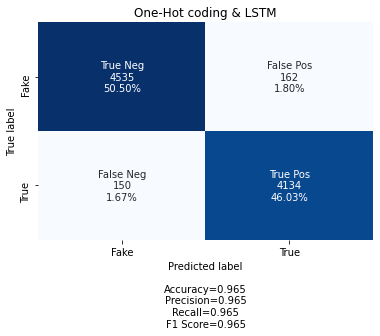

In [15]:
# Converting to one hot representation
voc_size = 5000
maxlen = 25
kwargs = {'n': voc_size}
print(X_train.shape)
# X_train_onehot_rep = np.apply_along_axis(tensorflow.keras.preprocessing.text.one_hot, 0,X_train,**kwargs)
X_train_onehot_rep = [tensorflow.keras.preprocessing.text.one_hot(words, voc_size) for words in X_train.tolist()]
X_test_onehot_rep = [tensorflow.keras.preprocessing.text.one_hot(words, voc_size) for words in X_test.tolist()]

# Padding Sentences to make them of same size
X_train_embedded_docs = np.array(
    tensorflow.keras.preprocessing.sequence.pad_sequences(X_train_onehot_rep, padding='pre', maxlen=maxlen))
X_test_embedded_docs = np.array(
    tensorflow.keras.preprocessing.sequence.pad_sequences(X_test_onehot_rep, padding='pre', maxlen=maxlen))

# We have used embedding layers with LSTM
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(voc_size, 40, input_length=maxlen))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# training model
model.fit(X_train_embedded_docs, y_train, epochs=20, batch_size=64)

#y_train_pred_2 = (model.predict(X_train_embedded_docs) > 0.5).astype("int32")
y_test_pred_2 = (model.predict(X_test_embedded_docs) > 0.5).astype("int32")

# train_accuracy=sklearn.metrics.accuracy_score(y_train, y_train_pred_2)
# print('train_accuracy=',train_accuracy)

# plot the confusion matix
plot_confusion_matrix(y_test, y_test_pred_2, title='One-Hot coding & LSTM')
accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred_2)
precision, recall, fbeta_score, _ = sklearn.metrics.precision_recall_fscore_support(y_test, y_test_pred_2,
                                                                                    average='micro')
# print(accuracy, precision, recall, fbeta_score)
metrics['classifier'].append('LSTM')
metrics['accuracy'].append(accuracy)
metrics['precision'].append(precision)
metrics['recall'].append(recall)
metrics['fbeta_score'].append(fbeta_score)


**2.   using TFIDF and Multiple cassifiers**




------------------------------ Running classifier =  Passive Aggressive
cv_params= {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0], 'clfmodel__random_state': [999], 'clfmodel__n_jobs': [-1], 'clfmodel__C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]), 'clfmodel__loss': ['hinge', 'squared_hinge']}
Performing grid search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 21.9min finished


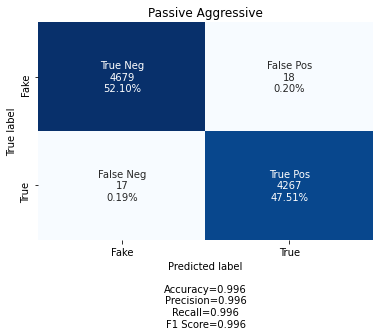

------------------------------ Running classifier =  Logistic Regression
cv_params= {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0], 'clfmodel__random_state': [999], 'clfmodel__n_jobs': [-1], 'clfmodel__C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]), 'clfmodel__penalty': ['l1', 'l2'], 'clfmodel__solver': ['sag', 'saga', 'lbfgs']}
Performing grid search...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 186.5min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


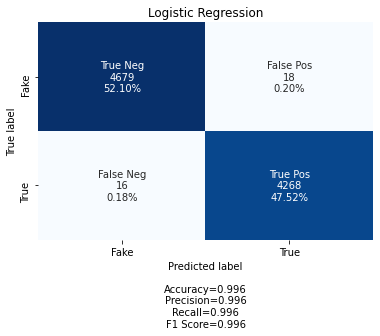

------------------------------ Running classifier =  Multinomial NB
cv_params= {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0]}
Performing grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


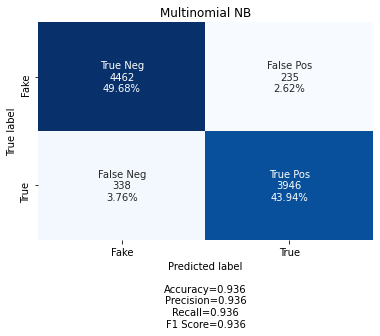

------------------------------ Running classifier =  Bernoulli NB
cv_params= {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0]}
Performing grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


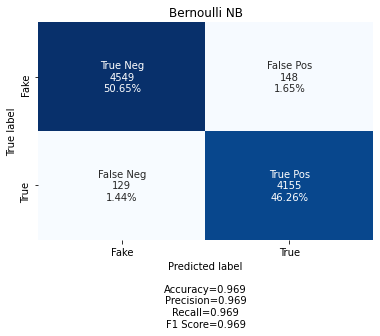

------------------------------ Running classifier =  Gradient Boosting
cv_params= {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0]}
Performing grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 43.9min finished


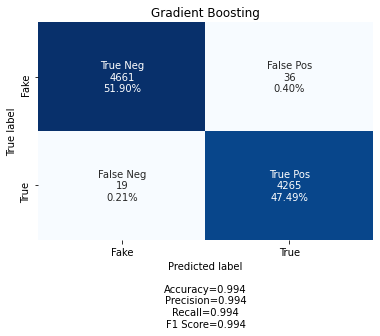

------------------------------ Running classifier =  Decision Tree
cv_params= {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0]}
Performing grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.2min finished


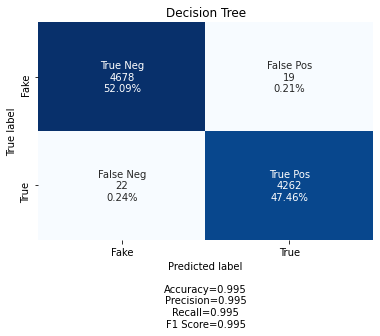

------------------------------ Running classifier =  Random Forest
cv_params= {'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0], 'clfmodel__random_state': [999], 'clfmodel__max_depth': [500]}
Performing grid search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 15.4min finished


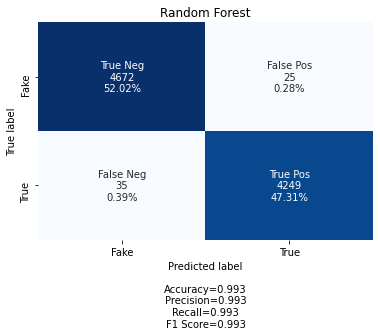

{'classifier': ['LSTM', 'Passive Aggressive', 'Logistic Regression', 'Multinomial NB', 'Bernoulli NB', 'Gradient Boosting', 'Decision Tree', 'Random Forest'], 'accuracy': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672], 'precision': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672], 'recall': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672], 'fbeta_score': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672]}


In [16]:
classifier_name_list = ['Passive Aggressive',
                        'Logistic Regression',
                        'Multinomial NB',
                        'Bernoulli NB',
                        'Gradient Boosting',
                        'Decision Tree',
                        'Random Forest',
                        ]

classifier_list = [sklearn.linear_model.PassiveAggressiveClassifier(),
                   sklearn.linear_model.LogisticRegression(),
                   sklearn.naive_bayes.MultinomialNB(),
                   sklearn.naive_bayes.BernoulliNB(),
                   sklearn.ensemble.GradientBoostingClassifier(),
                   sklearn.tree.DecisionTreeClassifier(),
                   sklearn.ensemble.RandomForestClassifier(),
                   ]

classifier_cv_params_pac = {'random_state': [999], 'n_jobs': [-1], 'C': np.logspace(-3, 3, 5),
                            'loss': ['hinge', 'squared_hinge'], }
classifier_cv_params_lr = {'random_state': [999], 'n_jobs': [-1], 'C': np.logspace(-3, 3, 5), 'penalty': ['l1', 'l2'],
                           'solver': ['sag', 'saga', 'lbfgs'], }
classifier_cv_params_mnb = {}
classifier_cv_params_bnb = {}
classifier_cv_params_gbc = {}
classifier_cv_params_dtc = {}
classifier_cv_params_rfc = {'random_state': [999],'max_depth': [500], }

classifier_cv_params_list = [classifier_cv_params_pac, classifier_cv_params_lr, classifier_cv_params_mnb,
                             classifier_cv_params_bnb, classifier_cv_params_gbc, classifier_cv_params_dtc,
                             classifier_cv_params_rfc]

for classifier_name, classifier, classifier_cv_params in zip(classifier_name_list, classifier_list,
                                                             classifier_cv_params_list):
    print('------------------------------ Running classifier = ', classifier_name)
    accuracy, precision, recall, fbeta_score = load_up_classifier(classifier_name, classifier, classifier_cv_params, X_train, X_test,
                                                                  y_train, y_test)
    metrics['classifier'].append(classifier_name)
    metrics['accuracy'].append(accuracy)
    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['fbeta_score'].append(fbeta_score)

print(metrics)


In [17]:
metrics_df=pd.DataFrame(metrics)
metrics_df.sort_values(by=['accuracy'], ascending=False).reset_index(drop=True)


,classifier,accuracy,precision,recall,fbeta_score
0,Logistic Regression,0.996214,0.996214,0.996214,0.996214
1,Passive Aggressive,0.996103,0.996103,0.996103,0.996103
2,Decision Tree,0.995435,0.995435,0.995435,0.995435
3,Gradient Boosting,0.993876,0.993876,0.993876,0.993876
4,Random Forest,0.993319,0.993319,0.993319,0.993319
5,Bernoulli NB,0.969157,0.969157,0.969157,0.969157
6,LSTM,0.965260,0.965260,0.965260,0.965260
7,Multinomial NB,0.936199,0.936199,0.936199,0.936199


In [30]:
metrics = {'classifier': ['LSTM', 'Passive Aggressive', 'Logistic Regression', 'Multinomial NB', 'Bernoulli NB', 'Gradient Boosting', 'Decision Tree', 'Random Forest'], 'accuracy': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672], 'precision': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672], 'recall': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672], 'fbeta_score': [0.9652599933192295, 0.9961028838659393, 0.9962142300411981, 0.9361986415766619, 0.9691571094532903, 0.9938759603607616, 0.9954348068143859, 0.9933192294844672]}
metrics_df=pd.DataFrame(metrics)
metrics_df=metrics_df.sort_values(by=['accuracy'], ascending=False).reset_index(drop=True)

metrics_df

,classifier,accuracy,precision,recall,fbeta_score
0,Logistic Regression,0.996214,0.996214,0.996214,0.996214
1,Passive Aggressive,0.996103,0.996103,0.996103,0.996103
2,Decision Tree,0.995435,0.995435,0.995435,0.995435
3,Gradient Boosting,0.993876,0.993876,0.993876,0.993876
4,Random Forest,0.993319,0.993319,0.993319,0.993319
5,Bernoulli NB,0.969157,0.969157,0.969157,0.969157
6,LSTM,0.965260,0.965260,0.965260,0.965260
7,Multinomial NB,0.936199,0.936199,0.936199,0.936199


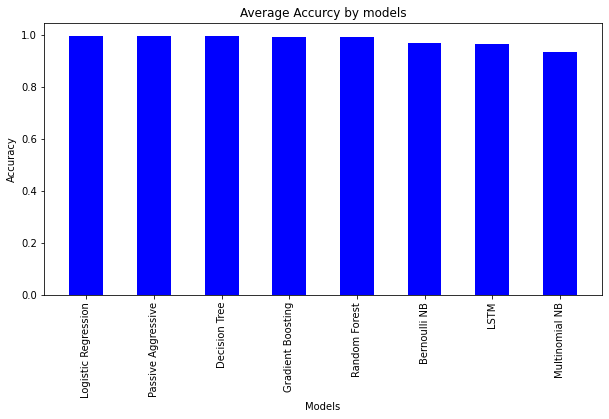

In [31]:
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(metrics_df.classifier, metrics_df.accuracy, color ='blue',width = 0.5)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Average Accurcy by models")
plt.xticks(rotation=90)
plt.show()

In [34]:
true_data_original.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [35]:
fake_data_original.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [36]:
true_data_original.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [37]:
fake_data_original.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [46]:
true_data_original.date.value_counts().sort_index().tail()

September 7, 2017     149
September 8, 2016      16
September 8, 2017     119
September 9, 2016       8
September 9, 2017      52
Name: date, dtype: int64

In [45]:
fake_data_original.date.value_counts().sort_index().tail()

https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/    1
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/        1
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/                                                                 1
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg                                                                                       3
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg                                                                               3
Name: date, dtype: int64